# Split sub-basins to domains for use in ATS simulations

Note this requires the use of the ATS meshing workflow, soon to be available at:

https://github.com/amanzi/meshing_workflow.git

but currently available at:

https://github.com/ecoon/ideal-octo-waffle.git

This also requires a pretty advanced, distinct python environment.  Install this via instructions from that repo.

This notebook converts the sub-basins identified as a part of the East River domain into four distinct shapefiles:

* East River domain
* Lower Triangle domain
* Copper Creek domain
* East River Above Copper Creek domain
* Rock Creek (a subset of East River above Copper Creek)

In [1]:
import fiona, shapely.geometry, shapely.ops
import collections
import numpy as np

import workflow.plot
import workflow.crs

In [2]:
# load the subdomain shapefile
subbasins = []
subbasins_f = []
with fiona.open('../data/domain_boundaries/EastRiver/subbasins/subbasins.shp','r') as fid:
    for shp in fid:
        subbasins_f.append(shp)
        subbasins.append(shapely.geometry.shape(shp['geometry']))
    input_profile = fid.profile.copy()
    driver = fid.driver
    crs = workflow.crs.from_fiona(fid.crs)
    crs_wkt = fid.crs_wkt

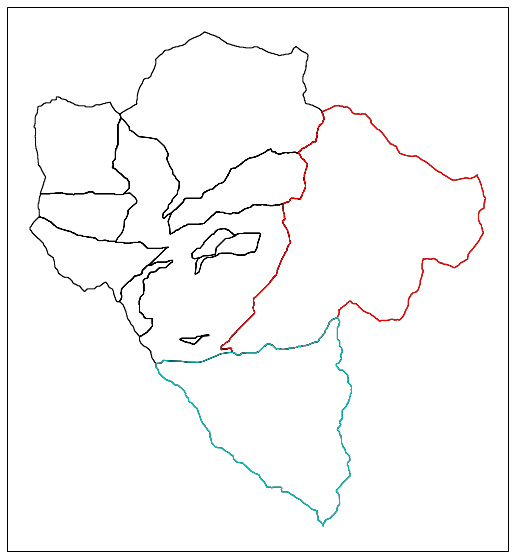

In [3]:
# find the east-most centroid (this should be the Copper Creek shape)
copper_creek = sorted(subbasins, key=lambda a: a.centroid.xy[0])[-1]

# find the southern-most centroid (this should be Lower East River / Lower Triangle)
lower_triangle = sorted(subbasins, key=lambda a: a.centroid.xy[1])[0]

# remainder are in East River above Copper Creek.  Plot and check
fig, ax = workflow.plot.get_ax(crs, figsize=(10,10))
workflow.plot.shply(subbasins, crs, ax=ax, color='k')
workflow.plot.shply([copper_creek,], crs, ax=ax, color='r')
workflow.plot.shply([lower_triangle,], crs, ax=ax, color='c')

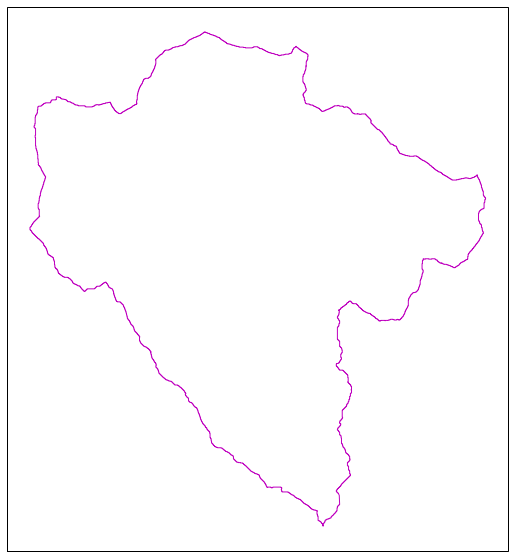

In [4]:
# generate the East River domain
er = shapely.ops.cascaded_union(subbasins)

# plot
fig, ax = workflow.plot.get_ax(crs, figsize=(10,10))
workflow.plot.shply([er,], crs, 'm', ax)


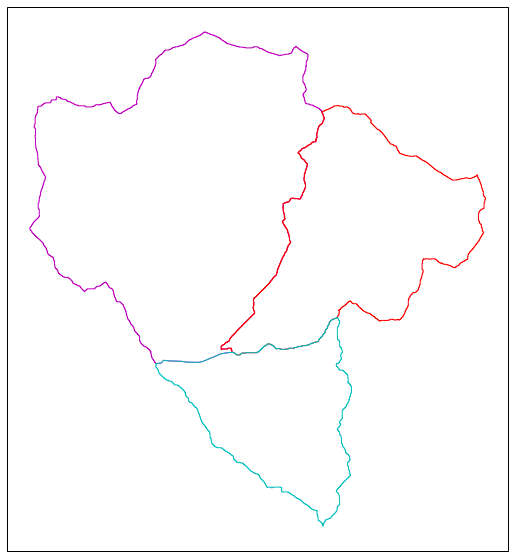

In [5]:
# generate a single subbasin for ERACC
eracc_l = subbasins[:]
cc_index = eracc_l.index(copper_creek)
eracc_l.remove(copper_creek)
subbasins_f = subbasins_f[0:cc_index] + subbasins_f[cc_index+1:]

lt_index = eracc_l.index(lower_triangle)
eracc_l.remove(lower_triangle)
subbasins_f = subbasins_f[0:lt_index] + subbasins_f[lt_index+1:]

eracc = shapely.ops.cascaded_union(eracc_l)

# plot
fig, ax = workflow.plot.get_ax(crs, figsize=(10,10))
workflow.plot.shply([eracc,], crs, 'm', ax)
workflow.plot.shply([copper_creek,], crs, 'r', ax)
workflow.plot.shply([lower_triangle,], crs, 'c', ax)

In [6]:
# write these subbasins to file for future use
schema = dict()
schema['geometry'] = 'Polygon'
schema['properties'] = collections.OrderedDict()
schema['properties']['name'] = 'str'

In [1]:
# east river
properties = collections.OrderedDict()
properties['name'] = 'east river'
with fiona.open('../data/domain_boundaries/EastRiver/EastRiver/east_river.shp', 'w', 
                driver=driver, crs=workflow.crs.to_fiona(crs), crs_wkt=crs_wkt, 
                schema=schema) as c:
    c.write({
        'geometry': shapely.geometry.mapping(er),
        'properties': properties,
    })

NameError: name 'collections' is not defined

In [8]:
# lower triangle
properties = collections.OrderedDict()
properties['name'] = 'lower triangle'
with fiona.open('../data/domain_boundaries/EastRiver/LowerTriangle/lower_triangle.shp', 'w',
                driver=driver, crs=workflow.crs.to_fiona(crs), crs_wkt=crs_wkt, schema=schema) as c:
    c.write({'geometry':shapely.geometry.mapping(lower_triangle),
             'properties':properties})

In [9]:
# copper creek
properties = collections.OrderedDict()
properties['name'] = 'copper creek'
with fiona.open('../data/domain_boundaries/EastRiver/CopperCreek/copper_creek.shp', 'w', 
                driver=driver, crs=workflow.crs.to_fiona(crs), crs_wkt=crs_wkt, schema=schema) as c:
    c.write({
        'geometry': shapely.geometry.mapping(copper_creek),
        'properties': properties,
    })

In [10]:
# East River above CC
properties = collections.OrderedDict()
properties['name'] = 'eracc'
with fiona.open('../data/domain_boundaries/EastRiver/ERACC/eracc.shp', 'w', 
                driver=driver, crs=workflow.crs.to_fiona(crs), crs_wkt=crs_wkt, schema=schema) as c:
    c.write({
        'geometry': shapely.geometry.mapping(eracc),
        'properties': properties,
    })

['Avery', 'Marmot', 'Benthette', 'Bradley', 'Rustlers', 'Gothic', 'Above EBC', 'Quigley', 'EAQ', 'Rock']
Rock


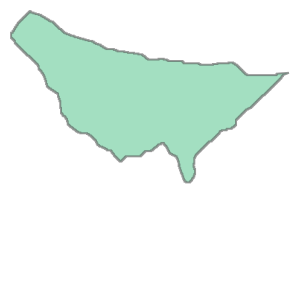

In [11]:
# Within ERACC, look for Rock Creek, a small subcatchment
print([sub['properties']['NAME'] for sub in subbasins_f])
print(subbasins_f[9]['properties']['NAME'])
eracc_l[9]

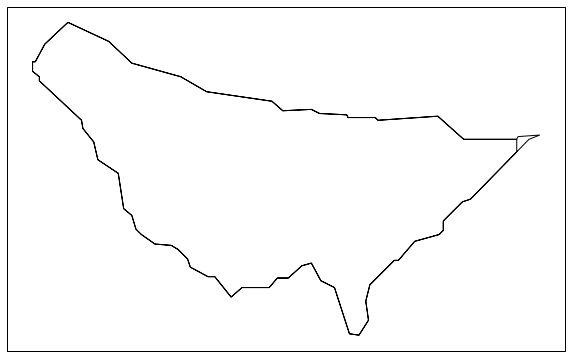

In [12]:
#
# Working with Rock Creek
#
# clip the right tip of the sub-basin, it makes trouble
test_subbasin = eracc_l[9]

# simplify to remove stairstepping from the underlying delineation
test_subbasin = test_subbasin.simplify(15)

# clip the rightmost point
boundary_points = np.array(test_subbasin.boundary.xy[:]).transpose()
boundary_points.shape

def pop_right(points):
    i_right = np.argmax(points[:,0])
    new_boundary_points = list(boundary_points)
    new_boundary_points.pop(i_right)
    return np.array(new_boundary_points)

for i in range(3):
    boundary_points = pop_right(boundary_points)
i_right = np.argmax(boundary_points[:,0])

x_clip = boundary_points[i_right,0]
x_min = boundary_points[:,0].min() - 1
y_min = boundary_points[:,1].min() - 1
y_max = boundary_points[:,1].max() + 1
clip_shape = shapely.geometry.Polygon([(x_min, y_min), (x_clip, y_min), (x_clip, y_max), (x_min, y_max)])

new_test_subbasin = test_subbasin.intersection(clip_shape)

fig, ax = workflow.plot.get_ax(crs, figsize=(10,10))
workflow.plot.shply([test_subbasin,new_test_subbasin], crs, ax=ax)

In [13]:
# save shape to disk
properties = collections.OrderedDict()
properties['name'] = 'Rock Creek'
with fiona.open('../data/domain_boundaries/EastRiver/RockCreek/rock_creek.shp', 'w', 
                driver=driver, crs=workflow.crs.to_fiona(crs), crs_wkt=crs_wkt, schema=schema) as c:
    c.write({
        'geometry': shapely.geometry.mapping(new_test_subbasin),
        'properties': properties,
    })